# Model

## Requirements

- import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

- functions

In [2]:
def get_data_schema(df: pd.DataFrame) -> dict:
    """
        `get_data_schema` generates data schema of a given dataframe.

        Parameters
        ----------
        df: `DataFrame`
            input dataset    

        Returns
        -------
        schema: `dict`
            required data schema in a `dict` where `keys` are COLUMN_NAMEs,\r
                and `values` are DATA TYPE.\    
        -----

        """
    schema = {}
    for col in df.columns:
        copy_df = df[[col]].copy()
        copy_df = copy_df[copy_df.isnull().any(axis=1) == False].head(1)
        schema[col] = "object"
        if copy_df.shape[0] == 0:
            continue
        schema[col] = str(copy_df.dtypes[0])
        if schema[col] != "object":
            continue
        if (
            pd.to_numeric(copy_df[col], errors="coerce", downcast="integer")
            .notnull()
            .all()
        ):
            schema[col] = "int64"
        elif (
            pd.to_numeric(copy_df[col], errors="coerce", downcast="float")
            .notnull()
            .all()
        ):
            schema[col] = "float64"
        elif pd.to_datetime(df[col], errors="coerce").notnull().all():
            schema[col] = "datetime64"

    return schema


def summarize_data(df, columns=None, n_visible_columns=10):
    def sum_data(df, col_name, is_date=False, is_cat=False):
        data = df[col_name].values
        n_digit = 2
        n = len(data)
        fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
        fig.subplots_adjust(wspace=0, top=1, right=1, left=0, bottom=0)
        if is_cat:
            in_valid = ["", "nan", "NA", "NULL", "None"]
            data = data.astype("str")
            is_null = np.in1d(data.astype("str"), in_valid)
            data[is_null] = "nan"
            unique_values, value_counts = np.unique(data, return_counts=True)
            index = np.argsort(value_counts)[::-1]
            unique_values, value_counts = (
                unique_values[index],
                value_counts[index],
            )

            if len(unique_values) > n_visible_columns:
                unique_values = np.append(unique_values[:n_visible_columns], "other")
                value_counts = np.append(
                    value_counts[:n_visible_columns],
                    value_counts[n_visible_columns:].sum(),
                )
            sum_df = {
                "Size": n,
                "Distinct": len(np.unique(data)),
                "Missing %": round(100 * is_null.sum() / n, n_digit),
            }
            for i, val in enumerate(unique_values[:5]):
                sum_df["{} %".format(val)] = round(100 * value_counts[i] / n, n_digit)

            ax[1].barh(unique_values, value_counts)
            ax[1].set_ylabel(col_name)
        elif is_date:
            data_num = data.astype("int64")
            sum_df = {
                "Size": n,
                "Distinct": len(np.unique(data)),
                "Missing %": round(100 * np.isnat(data).sum() / n, n_digit),
                "Zeros %": round(100 * (data_num == 0).sum() / n, n_digit),
                "Mean": np.datetime_as_string(
                    np.datetime64(int(np.nanmean(data_num)), "ns"), "D"
                ),
                "Median": np.datetime_as_string(
                    np.datetime64(int(np.nanmedian(data_num)), "ns"), "D"
                ),
                "Range": [
                    np.datetime_as_string(
                        np.datetime64(int(np.nanmin(data)), "ns"), "D"
                    ),
                    np.datetime_as_string(
                        np.datetime64(int(np.nanmax(data)), "ns"), "D"
                    ),
                ],
                "IQR": [
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 25)), "ns"), "D"
                    ),
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 75)), "ns"), "D"
                    ),
                ],
                "95 % CI": [
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 2.5)), "ns"), "D"
                    ),
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 97.5)), "ns"), "D"
                    ),
                ],
            }
            ax[1].hist(data, 20, edgecolor="white")
            ax[1].set_xlabel(col_name)
        else:
            sum_df = {
                "Size": n,
                "Distinct": len(np.unique(data)),
                "Missing %": round(100 * np.isnan(data).sum() / n, n_digit),
                "Zeros %": round(100 * (data.astype("float") == 0).sum() / n, n_digit),
                "Mean": round(np.nanmean(data), n_digit),
                "Median": round(np.nanmedian(data), n_digit),
                "St. Dev.": round(np.nanstd(data), n_digit),
                "Range": [
                    round(np.nanmin(data), n_digit),
                    round(np.nanmax(data), n_digit),
                ],
                "IQR": [
                    round(np.nanpercentile(data, 25), n_digit),
                    round(np.nanpercentile(data, 75), n_digit),
                ],
                "95 % CI": [
                    round(np.nanpercentile(data, 2.5), n_digit),
                    round(np.nanpercentile(data, 97.5), n_digit),
                ],
            }
            ax[1].hist(data, 20, edgecolor="white")
            ax[1].set_xlabel(col_name)

        the_table = ax[0].table(
            cellText=list(sum_df.items()),
            colLabels=["metric", "value"],
            bbox=[0.0, 0.0, 0.75, 1],
        )
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(9)
        the_table.auto_set_column_width(col=[0])
        # Hide the box border
        for key, cell in the_table._cells.items():
            cell.set_linestyle("-")
            cell.set_edgecolor("gray")
            cell.set_linewidth(0.5)
        ax[0].axis("off")
        ax[0].axis("tight")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.show()

    df = df.copy()
    if columns == None:
        columns = df.columns
    datetime_columns = df.select_dtypes(include=["datetime64", "<M8"]).columns.tolist()
    categorical_columns = df.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    for col_name in columns:
        if (
            df[col_name].dtype not in categorical_columns
            and len(df[col_name].unique()) < 10
        ):
            categorical_columns.append(col_name)
            df[col_name] = df[col_name].astype("category")
        data = df[col_name].values
        sum_data(
            df,
            col_name,
            is_cat=(col_name in categorical_columns),
            is_date=(col_name in datetime_columns),
        )
    
def xy_violinplot(df: pd.DataFrame, target: str, feature: str) -> None:
    _, ax = plt.subplots()
    sns.violinplot(data=df, x=target, y=feature, ax=ax, orient="v")
    plt.show()


def xy_barplot(
    df: pd.DataFrame, target: str, features, top_k=20, percentage=False
):
    by = features + [target]
    sum_df = df.groupby(by).size().nlargest(top_k).unstack()

    _, ax = plt.subplots()
    if percentage:
        sum_df.apply(lambda x: x / x.sum(), axis=1).plot(
            kind="bar", stacked=True, ax=ax
        )
        ax.set_ylabel("percentage")
    else:
        sum_df.plot(kind="bar", stacked=True, ax=ax)
        ax.set_ylabel("frequency")

    plt.show()


def xy_scatterplot(df: pd.DataFrame, x_col: str, y_col: str, color=None) -> None:

    _, ax = plt.subplots()
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=color)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    plt.title("")
    plt.suptitle("")
    plt.show()


def feature_importance(
    x: np.array,
    y: np.array,
    features,
    top_k: int = 20,
    is_classifer: bool = False,
    verbos=True,
) -> pd.DataFrame:
    """
    `feature_importance` gives x and y datasets and returns feature importance

    Parameters
    ----------
    x: `np.array`
        x dataset.
    y: `np.array`
        y dataset.
    features: `list[str]`
        list of features
    top_k: `int`
        top k features, users want to have in output plot. By default is 20
    is_classifer: `bool`
        a flag to set if the problem is regression or classification. By default is `True`
    verbos: `bool`
        a flag to print results. Be default is `True`

    Returns
    -------
    importance_df: `pd.DataFrame`
        a dataframe storing features and their score.

    Notes
    -----
    """
    model = XGBRegressor()
    if is_classifer:
        model = XGBClassifier()
    model.fit(x, y)
    importance = model.feature_importances_
    importance_df = pd.DataFrame({"feature": features, "score": importance})
    importance_df.sort_values(by="score", ascending=False, inplace=True)

    if verbos:
        print("TOP {} important features".format(top_k))
        print(importance_df.head(top_k))

    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    ax.barh(
        importance_df["feature"].values[:top_k], importance_df["score"].values[:top_k]
    )
    ax.set_title("Feature Importance")
    ax.set_xlabel("score")
    ax.set_ylabel("feature")
    plt.show(block=False)
    return importance_df

def train_a_model(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_val: np.ndarray,
    y_val: np.ndarray,
    model: object,
    verbos: bool = True,
    class_weight: dict = None,
):
    if class_weight == None:
        classes = np.unique(y_train)
        class_weight = {c: 1 / len(classes) for c in classes}

    def get_metrics(
        actual: np.ndarray,
        predicted: np.ndarray,
        predicted_probabilities: np.ndarray,
    ) -> dict:
        sample_weight = [class_weight[i] for i in predicted]
        accuracy = accuracy_score(actual, predicted, sample_weight=sample_weight)
        precision = precision_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        recall = recall_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        f1 = f1_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        auc = roc_auc_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        kappa = cohen_kappa_score(actual, predicted, sample_weight=sample_weight)
        mcc = matthews_corrcoef(actual, predicted, sample_weight=sample_weight)
        logloss = log_loss(actual, predicted_probabilities, sample_weight=sample_weight)

        metrics = {
            "Accuracy": accuracy,
            "AUC": auc,
            "Recall": recall,
            "Precision": precision,
            "F1-Score": f1,
            "Kappa": kappa,
            "MCC": mcc,
            "Log Loss": logloss,
        }

        return metrics

    t = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(x_train, y_train)
        t = time.time() - t
        y_pred = model.predict(x_train)
        y_prob = model.predict_proba(x_train)
        train_metrics = get_metrics(y_train, y_pred, y_prob)
        train_metrics["Training Time"] = t
        # do predictions
        y_pred = model.predict(x_val)
        y_prob = model.predict_proba(x_val)
        val_metrics = get_metrics(y_val, y_pred, y_prob)
        val_metrics["Training Time"] = t

    if verbos:
        df = pd.DataFrame(
            {
                "metrics": train_metrics.keys(),
                "train": train_metrics.values(),
                "validation": val_metrics.values(),
            }
        )
        default_format = pd.options.display.float_format
        pd.options.display.float_format = "{:,.2f}".format
        print("\n*******\nResults for model {}:\n".format(model))
        display(df)
        pd.options.display.float_format = default_format

    return model, val_metrics


def compare_models(
    x_train: np.ndarray,
    y_train: np.ndarray,
    models: dict,
    random_state: int = 123,
) -> object:
    def sort_output(df: pd.DataFrame):
        a = df.iloc[:, 1:-1].values
        a[:, :-1] = (a[:, :-1] - a[:, :-1].min(axis=0)) / (
            a[:, :-1].max(axis=0) - a[:, :-1].min(axis=0)
        )
        a[:, -1] = (a[:, -1].max(axis=0) - a[:, -1]) / (
            a[:, -1].max(axis=0) - a[:, -1].min(axis=0)
        )
        a = a.sum(axis=1)
        a = np.argsort(a)[::-1]
        return a

    def style_output(df: pd.DataFrame) -> pd.DataFrame:
        def highlight_max(s, props=""):
            return np.where(s == np.nanmax(s.values), props, "")

        def highlight_min(s, props=""):
            return np.where(s == np.nanmin(s.values), props, "")

        return df.style.apply(
            highlight_min,
            axis=0,
            props="background-color:yellow;",
            subset=df.columns.tolist()[-2:],
        ).apply(
            highlight_max,
            axis=0,
            props="background-color:yellow;",
            subset=df.columns.tolist()[1:-2],
        )


    exp = []
    metrics = []
    N_FOLD = 5
    kfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=random_state)

    for key, value in models.items():
        steps = [("norm", MinMaxScaler()), ("model", value)]
        model = Pipeline(steps=steps)
        res = []
        fold = 1
        for i_in, i_out in kfold.split(x_train, y_train):
            print(
                "training a {} (fold {} of {})...".format(key, fold, N_FOLD),
                end="\r",
            )
            _, scores = train_a_model(
                x_train[i_in, :],
                y_train[i_in],
                x_train[i_out, :],
                y_train[i_out],
                model,
                verbos=False,
            )
            print(
                "{} (fold {} of {}) Accuracy = {:.2f}".format(
                    key, fold, N_FOLD, scores["Accuracy"]
                ),
                end="\r",
            )
            res.append(list(scores.values()))
            fold += 1

        print(
            key
            + "\t"
            + "".join(
                [
                    "{}: {:.2f}\t".format(k, val)
                    for k, val in zip(list(scores.keys()), np.mean(res, axis=0))
                ]
            )
        )

        metrics = ["Model"] + list(scores.keys())
        res = [key] + list(np.mean(res, axis=0))

        exp.append(res)

    exp = pd.DataFrame(exp, columns=metrics)
    sort_index = sort_output(exp)
    exp = style_output(exp.iloc[sort_index, :])
    display(exp)
    return list(models.values())[sort_index[0]]


## EDA

### Load Data

In [4]:
filename = "..\\data\\train.csv"
train_df = pd.read_csv(filename)

filename = "..\\data\\test.csv"
test_df = pd.read_csv(filename)
test_df['Target'] = None
test_id = test_df['id'].values
train_df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


- check data type

In [5]:
data_schema = get_data_schema(train_df)
data_schema

{'id': 'int64',
 'Marital status': 'int64',
 'Application mode': 'int64',
 'Application order': 'int64',
 'Course': 'int64',
 'Daytime/evening attendance': 'int64',
 'Previous qualification': 'int64',
 'Previous qualification (grade)': 'float64',
 'Nacionality': 'int64',
 "Mother's qualification": 'int64',
 "Father's qualification": 'int64',
 "Mother's occupation": 'int64',
 "Father's occupation": 'int64',
 'Admission grade': 'float64',
 'Displaced': 'int64',
 'Educational special needs': 'int64',
 'Debtor': 'int64',
 'Tuition fees up to date': 'int64',
 'Gender': 'int64',
 'Scholarship holder': 'int64',
 'Age at enrollment': 'int64',
 'International': 'int64',
 'Curricular units 1st sem (credited)': 'int64',
 'Curricular units 1st sem (enrolled)': 'int64',
 'Curricular units 1st sem (evaluations)': 'int64',
 'Curricular units 1st sem (approved)': 'int64',
 'Curricular units 1st sem (grade)': 'float64',
 'Curricular units 1st sem (without evaluations)': 'int64',
 'Curricular units 2nd 

- convert data types

In [6]:
for key, value in data_schema.items():
    train_df[key] = train_df[key].values.astype(value)
    test_df[key] = test_df[key].values.astype(value)

### Data Profile

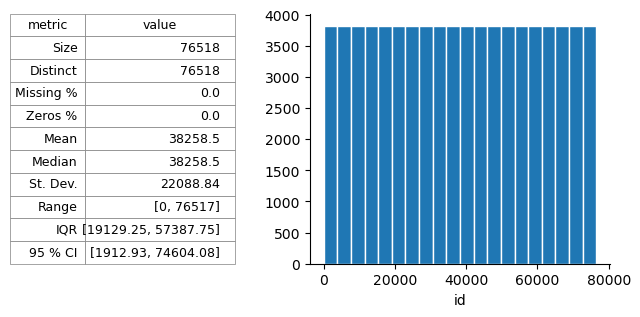

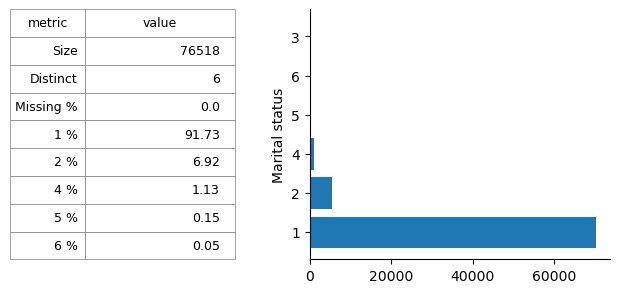

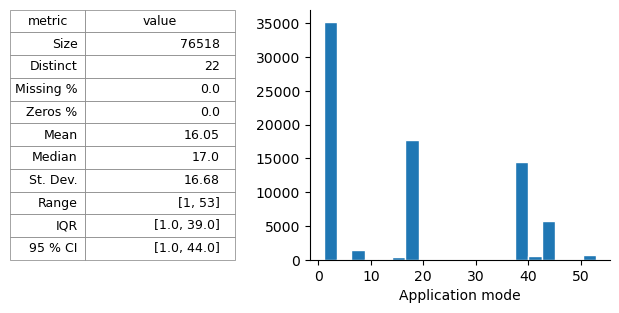

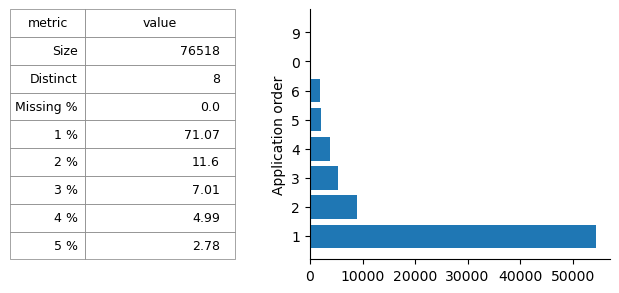

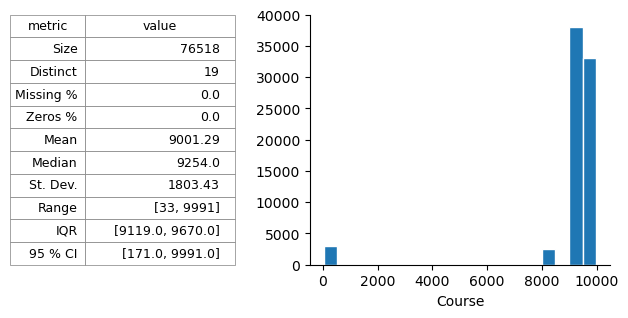

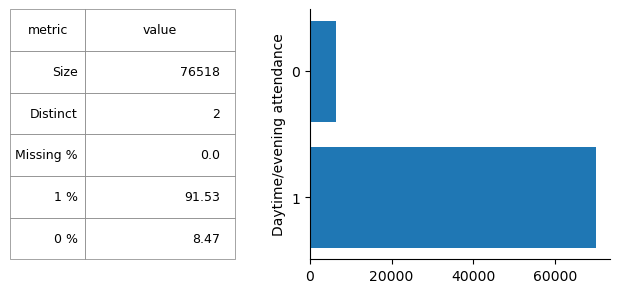

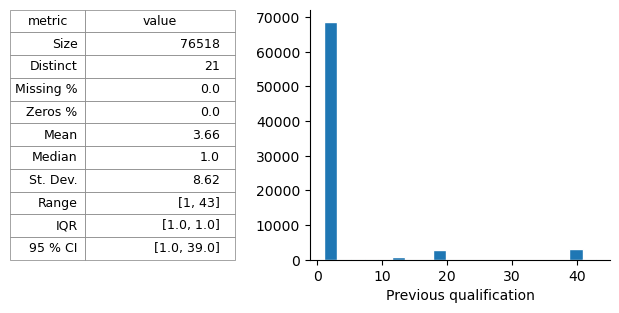

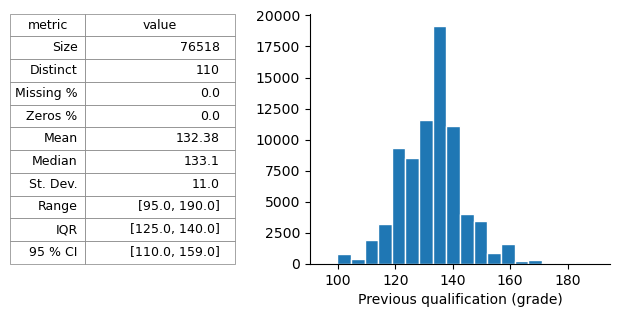

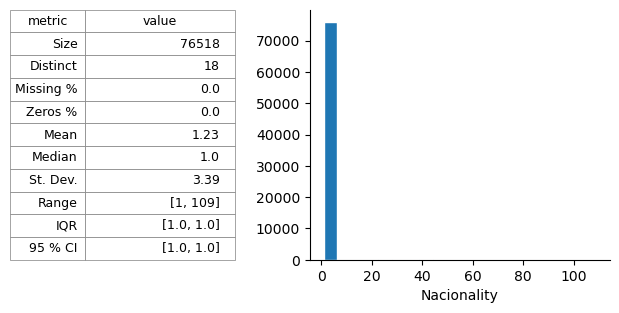

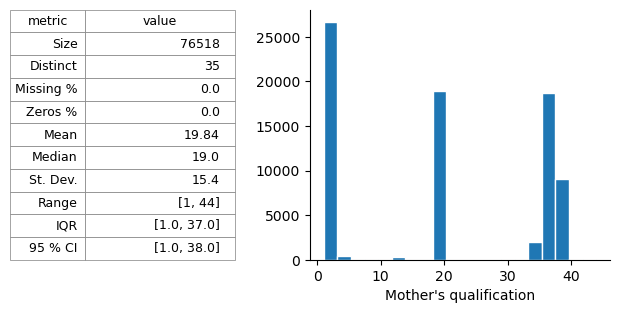

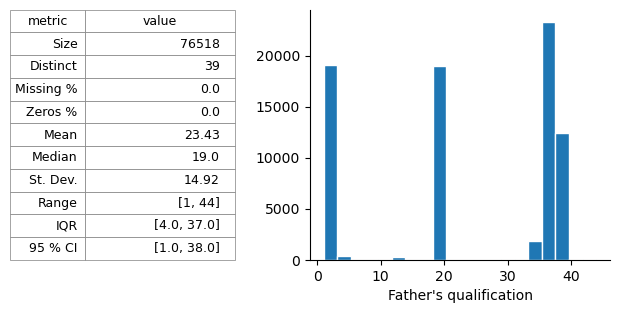

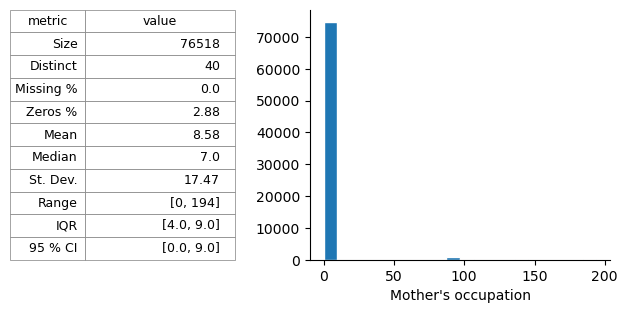

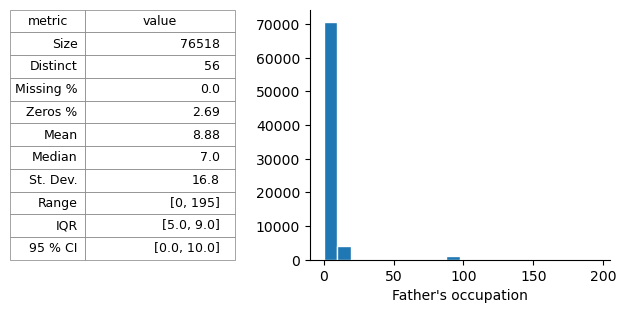

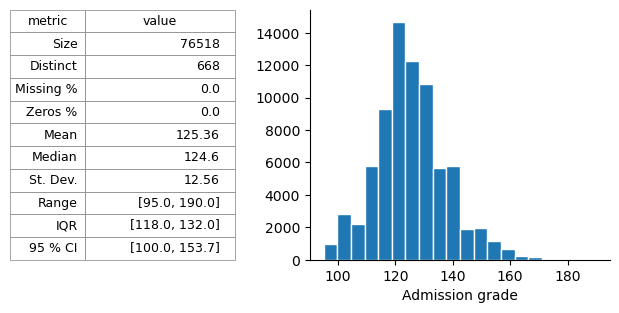

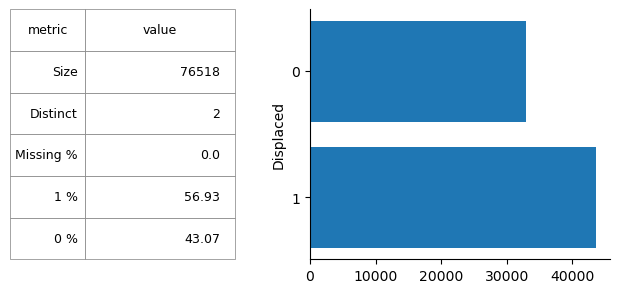

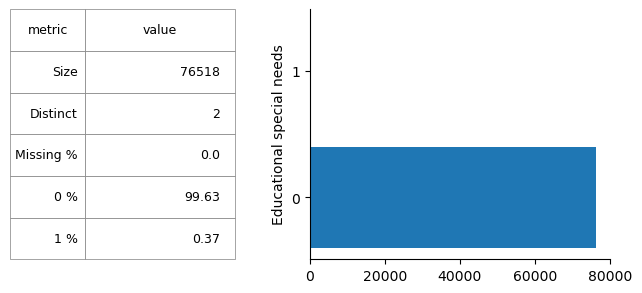

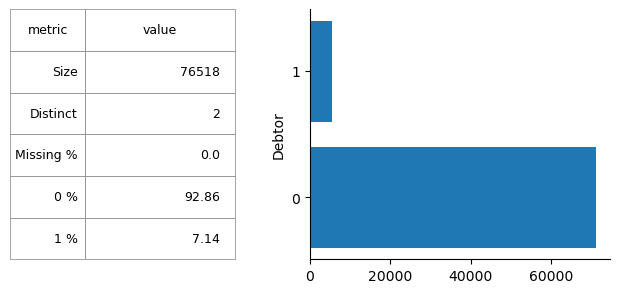

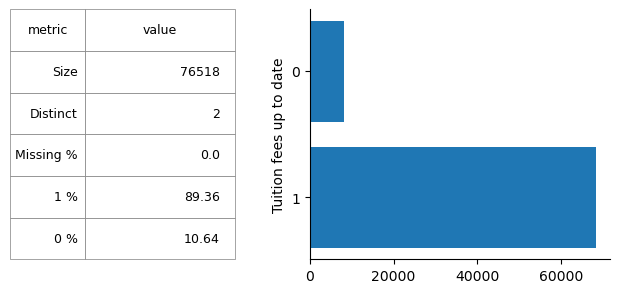

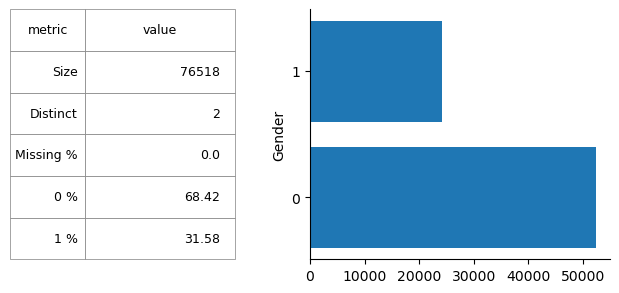

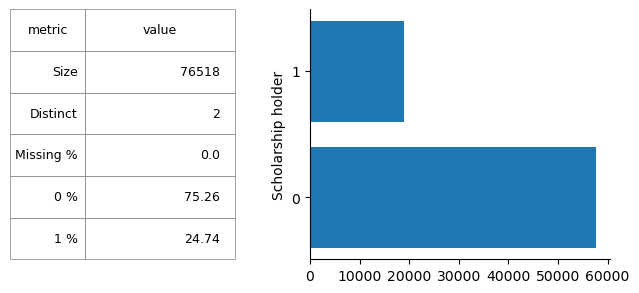

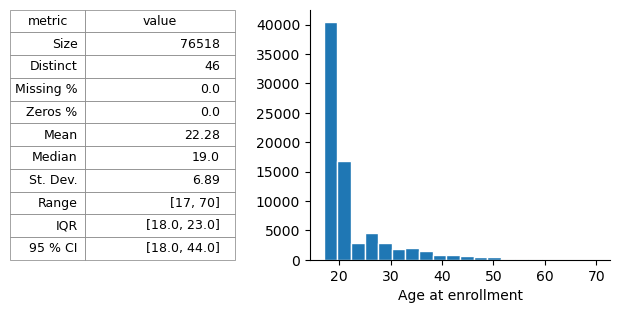

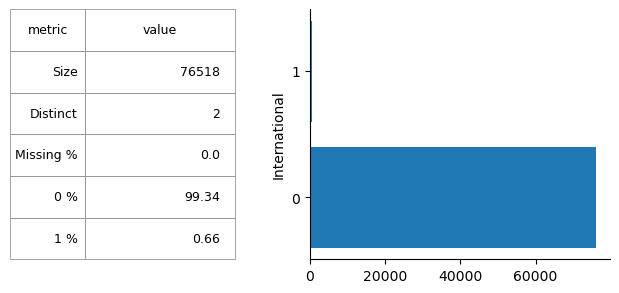

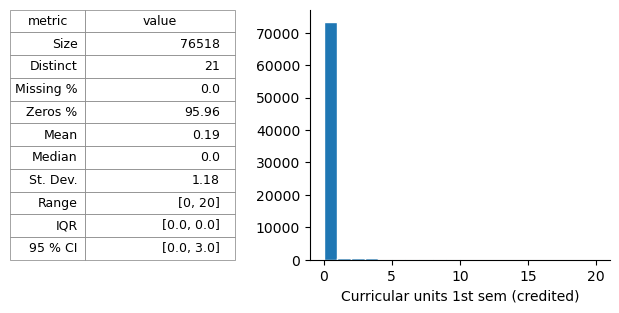

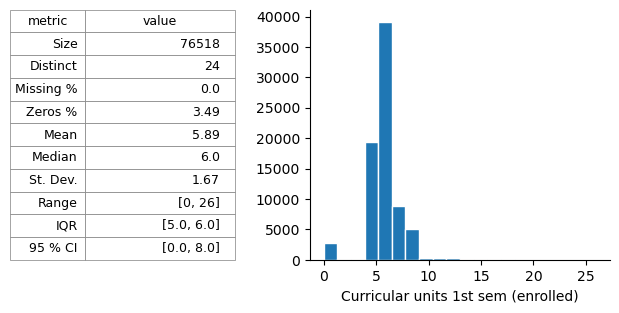

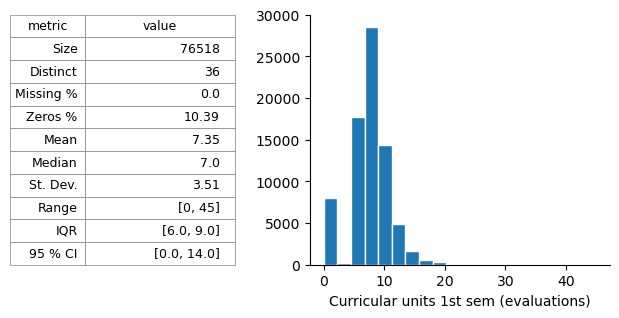

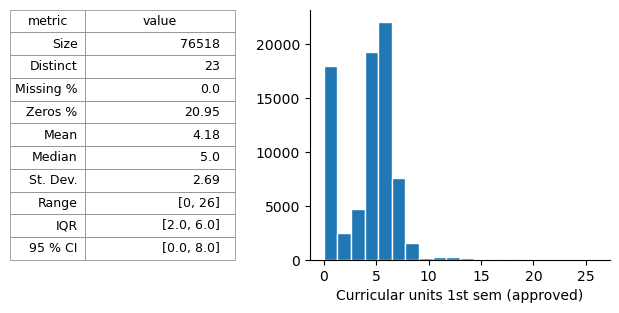

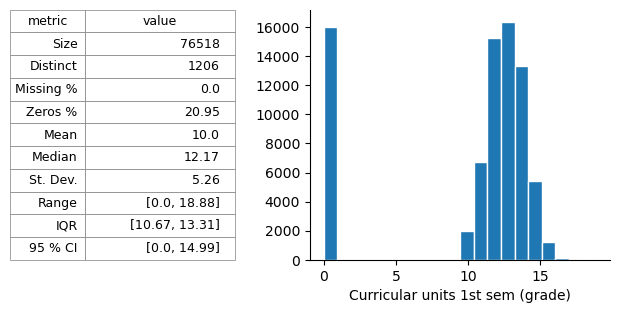

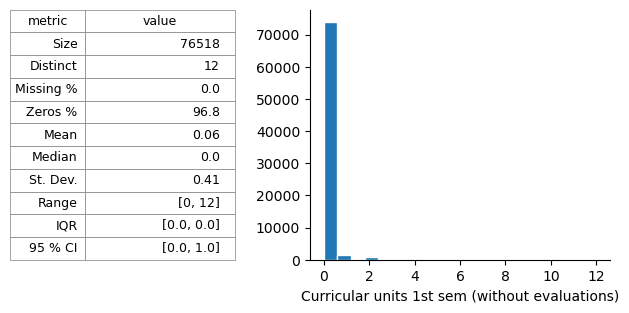

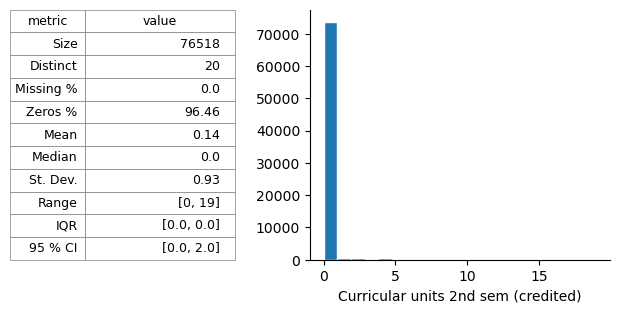

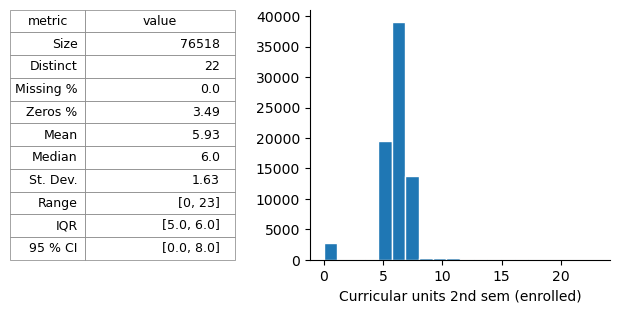

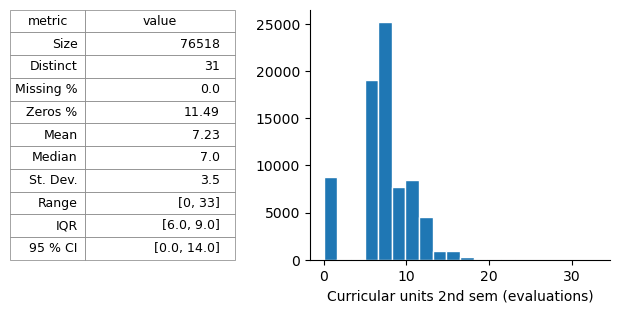

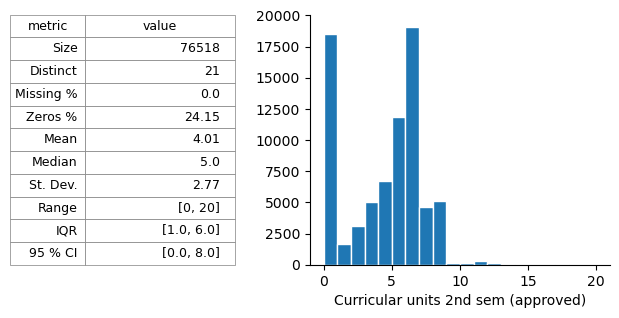

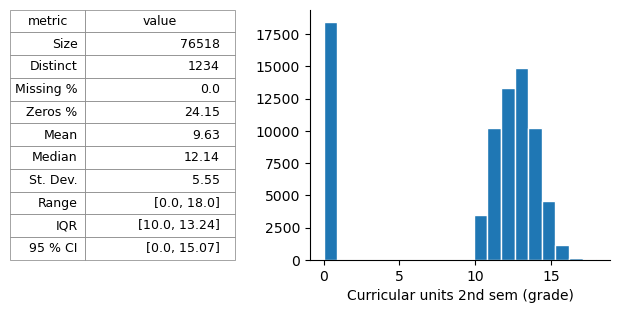

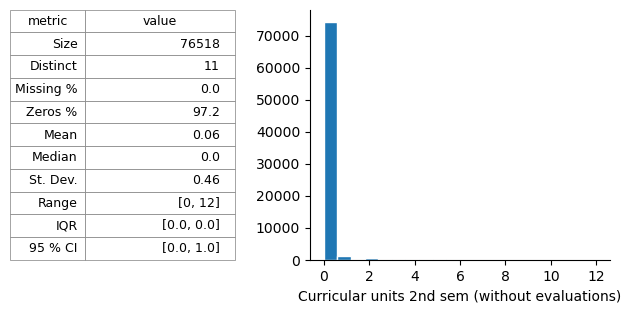

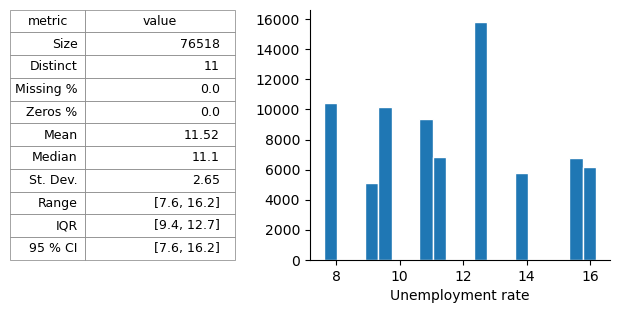

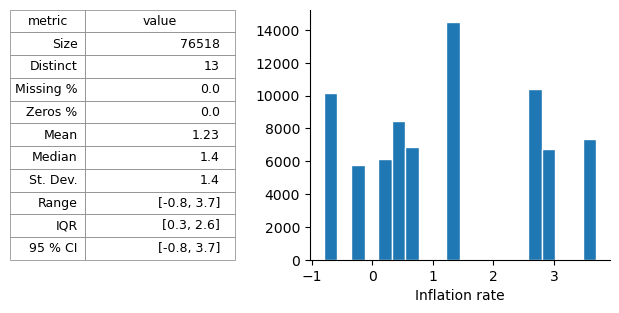

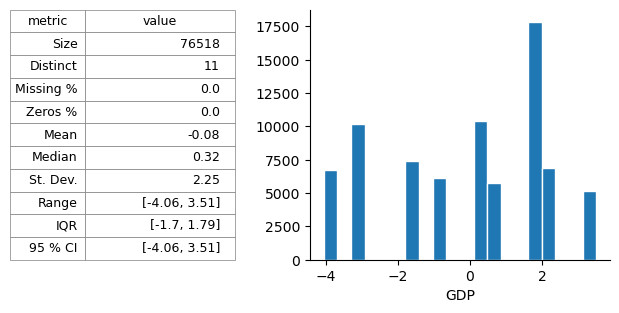

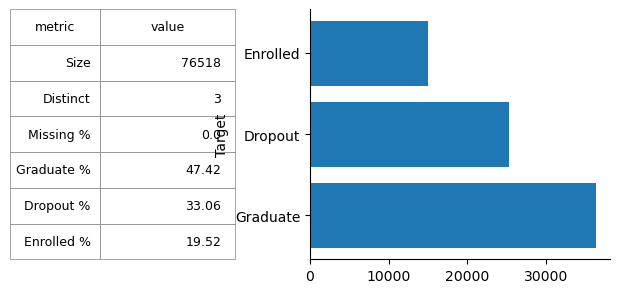

In [7]:
summarize_data(train_df)

In [9]:
label_encoder = LabelEncoder()
train_df['Target'] = label_encoder.fit_transform(train_df['Target'])

### XY correlations

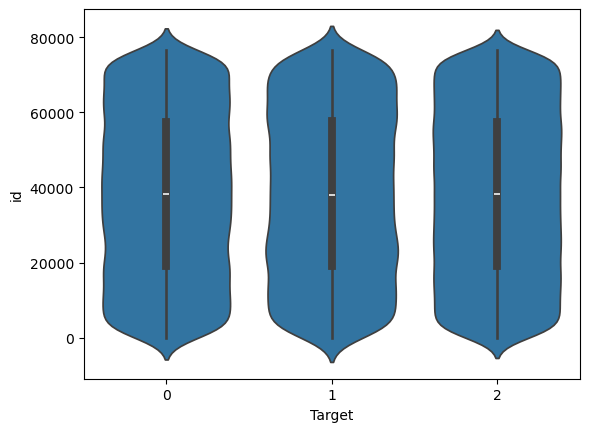

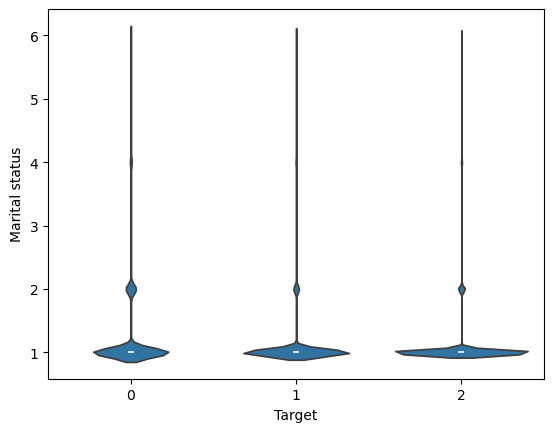

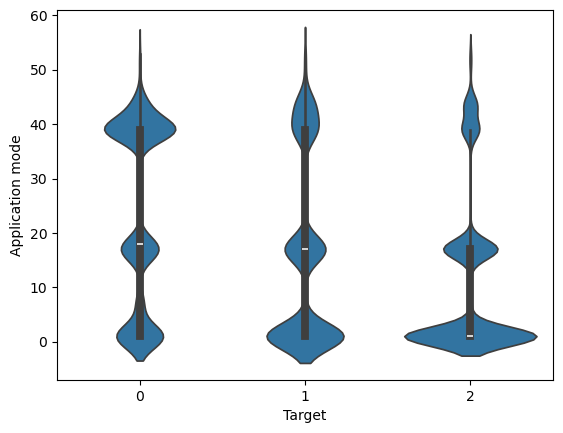

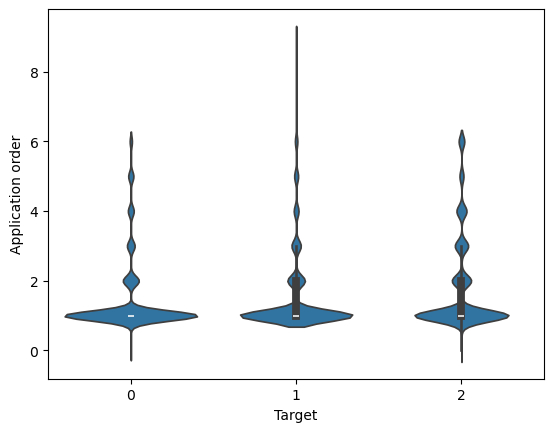

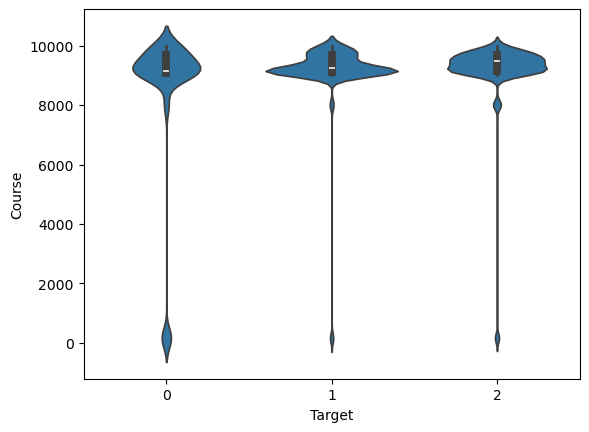

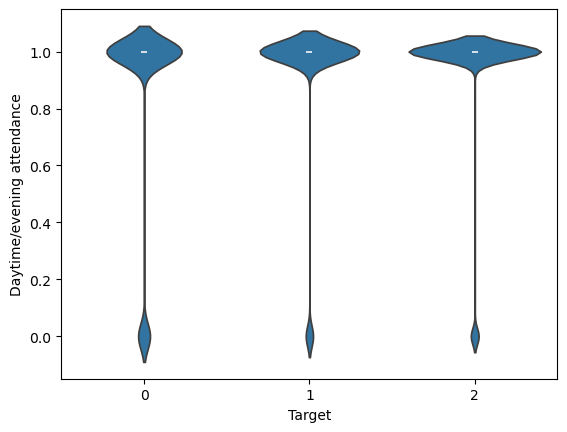

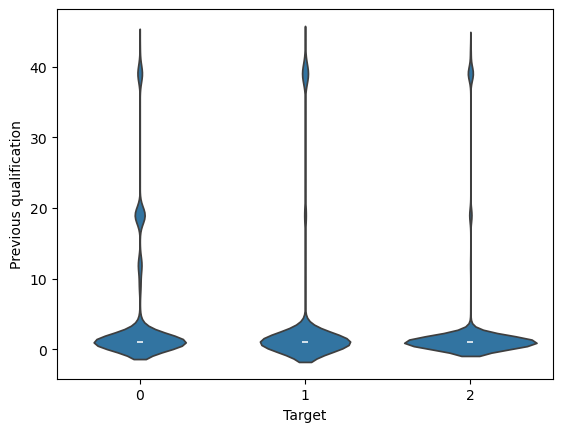

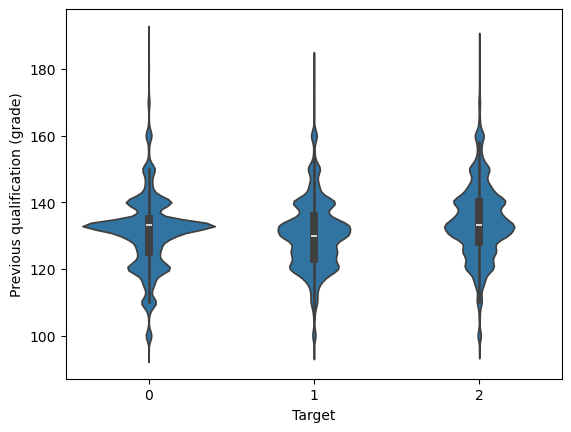

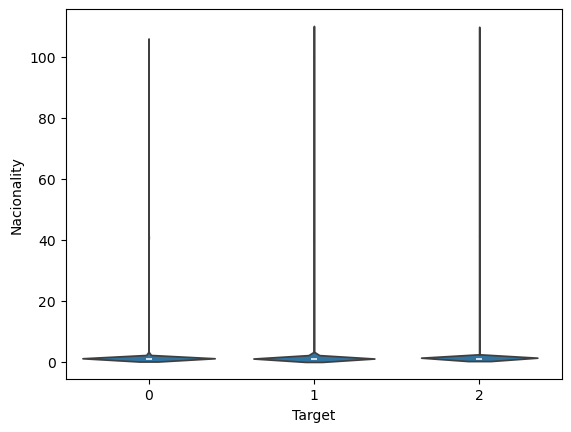

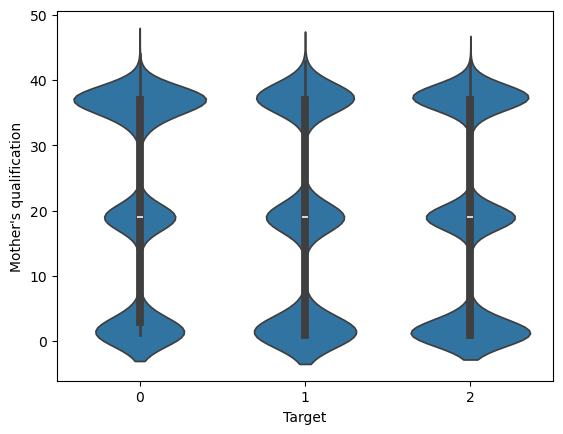

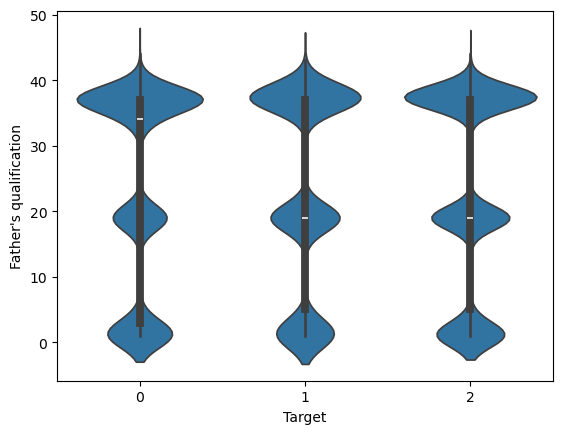

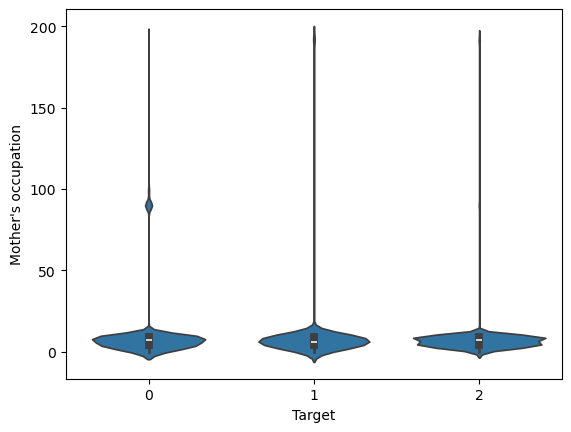

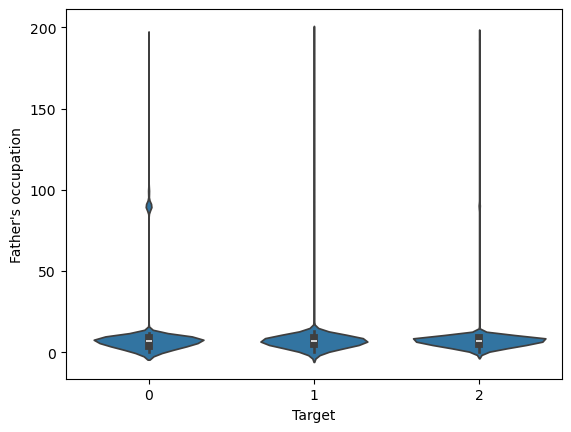

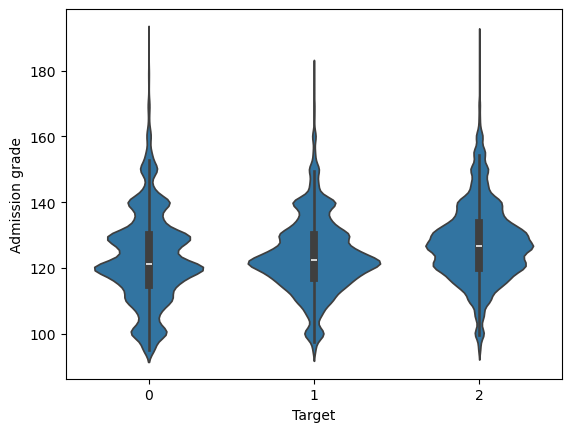

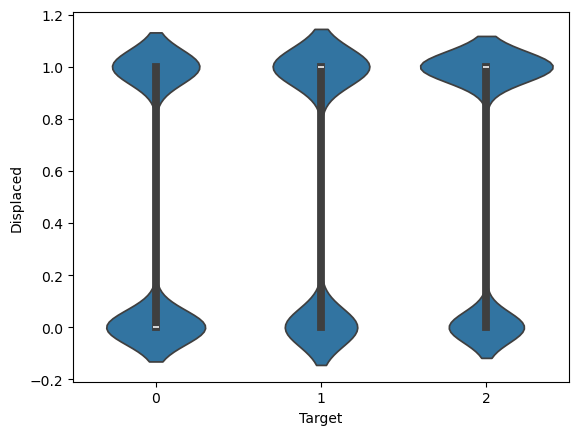

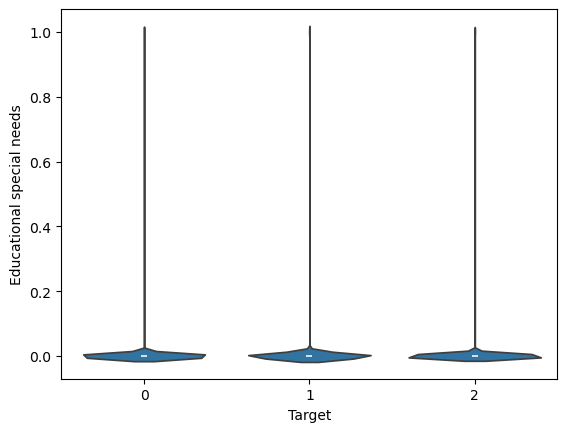

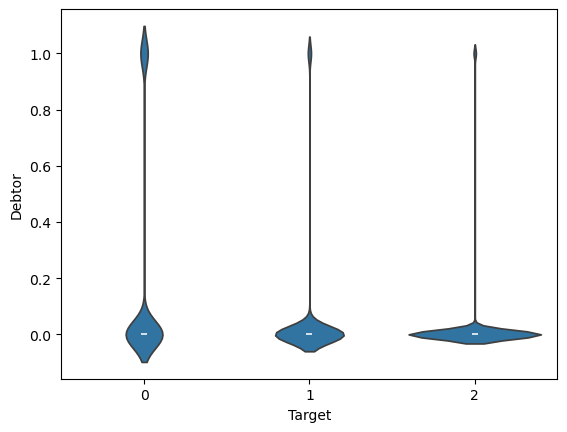

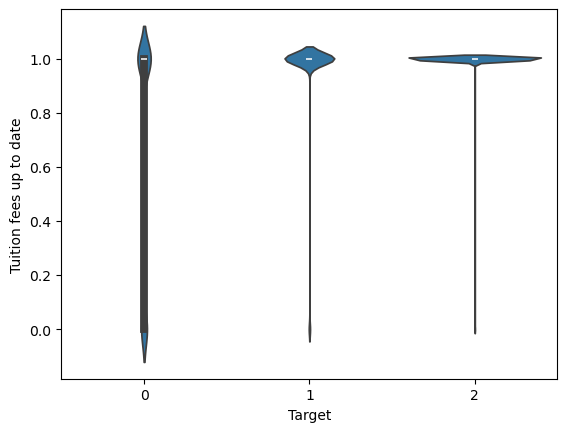

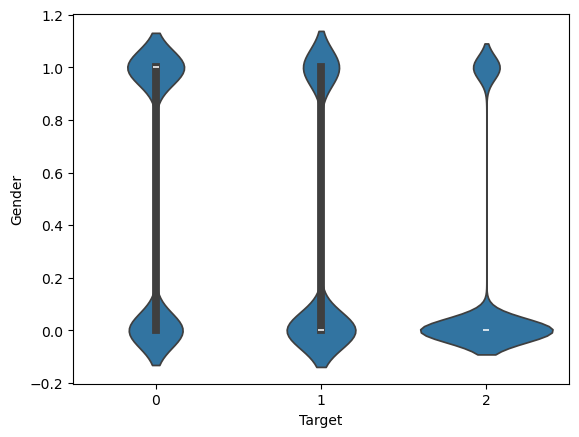

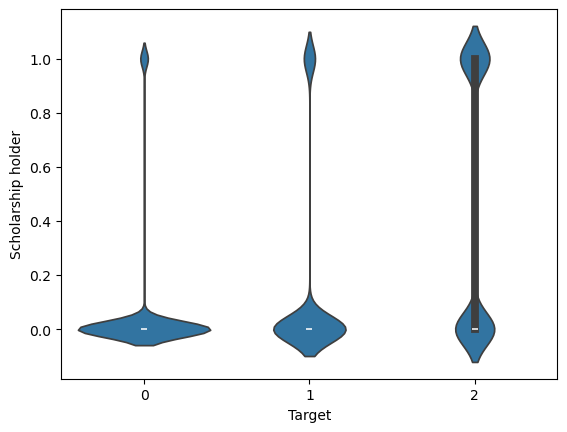

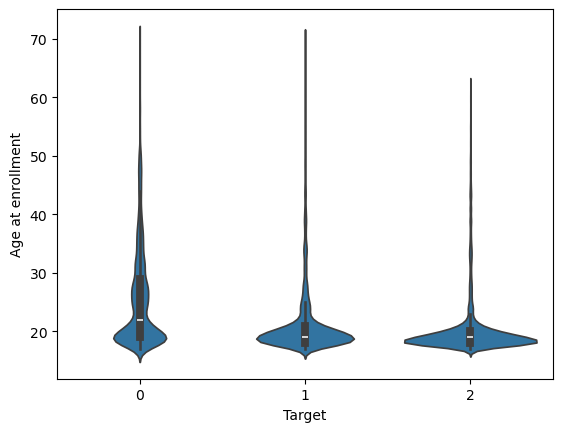

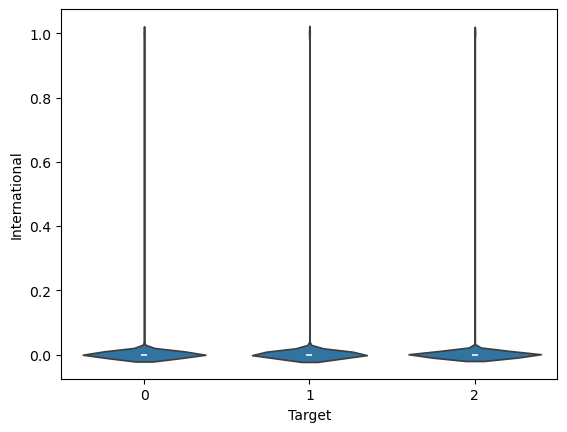

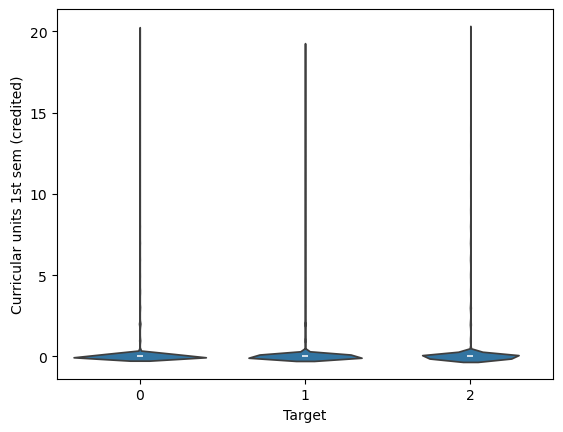

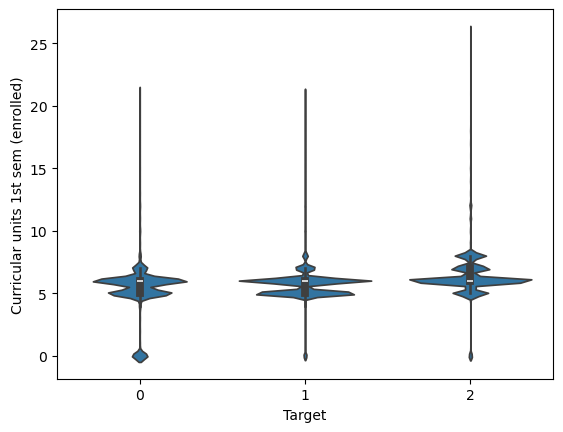

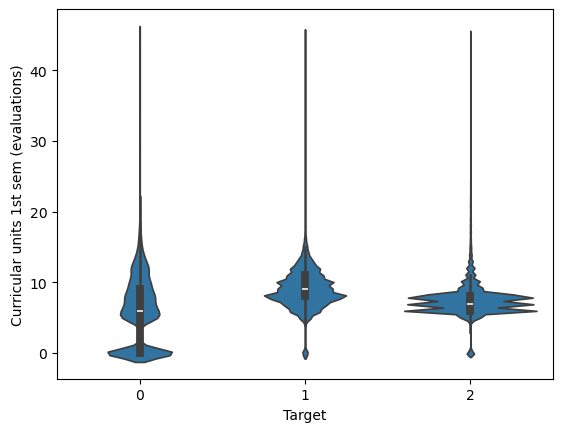

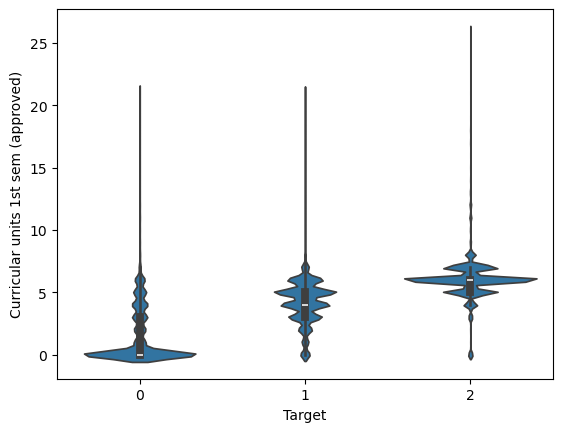

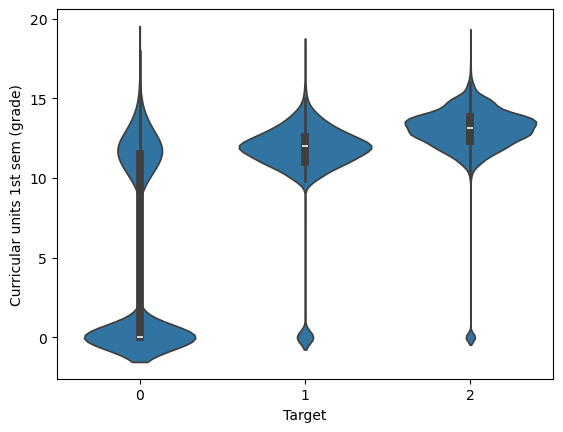

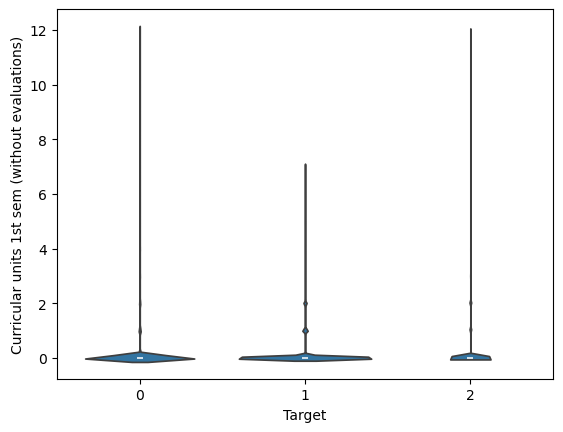

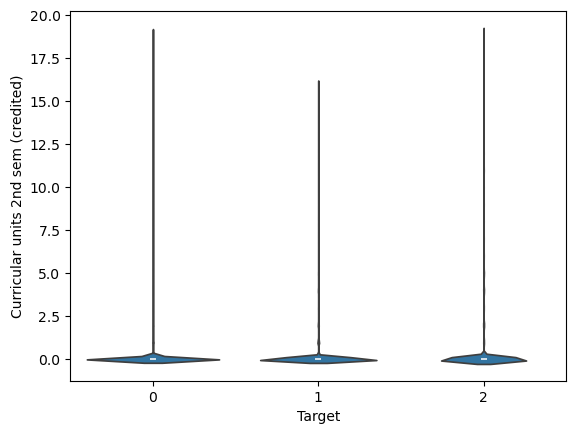

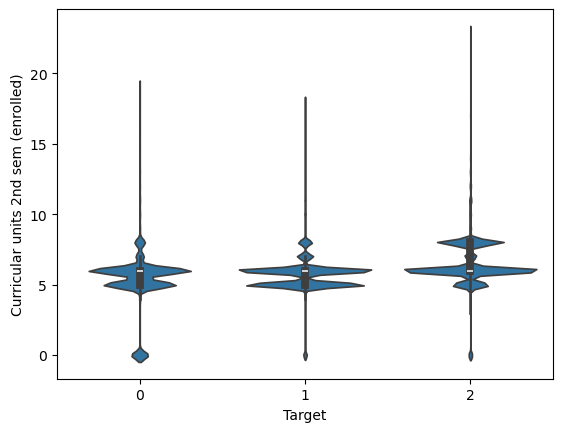

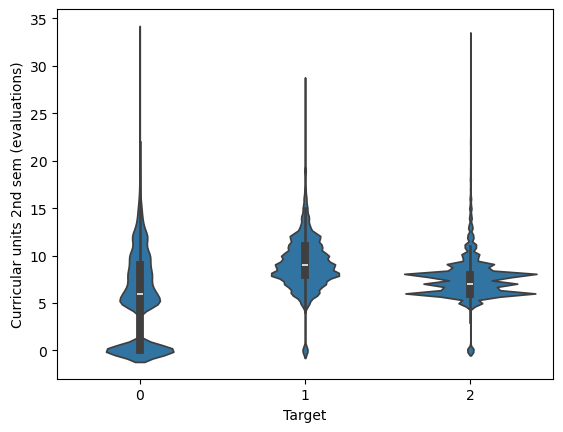

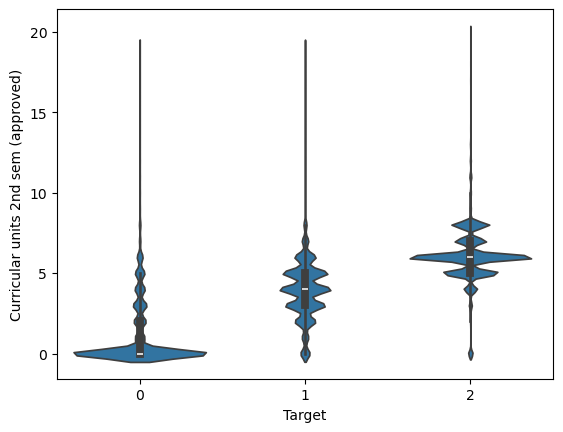

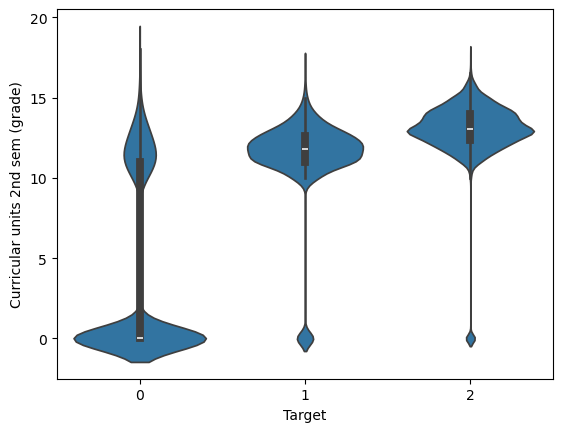

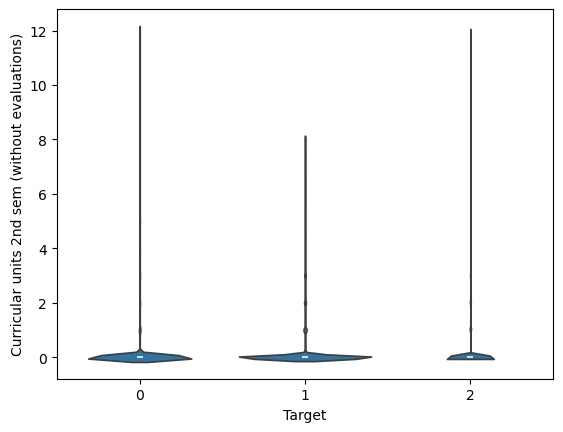

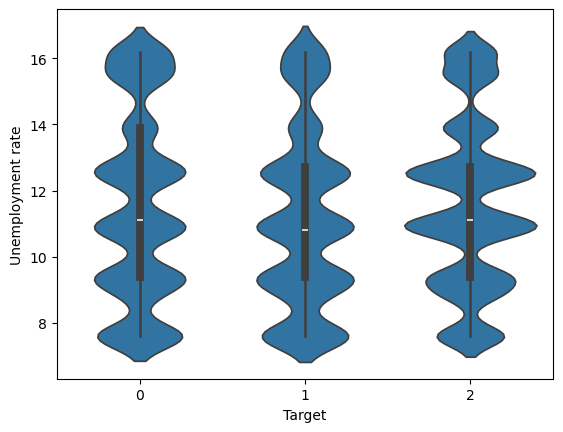

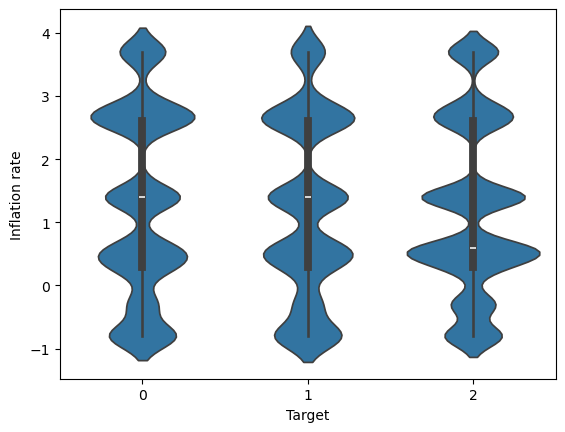

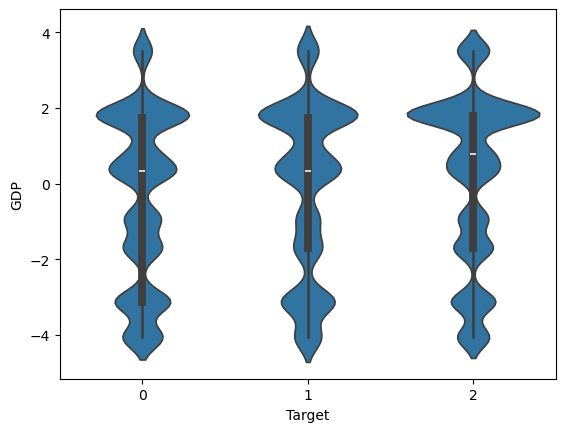

In [11]:
target = train_df.columns[-1]
for col, dtype in data_schema.items():
    if col == target:
        continue
    if dtype != "object":
        xy_violinplot(train_df, target, col)
    else:
        xy_barplot(train_df, target, [col])

### Feature Engineering

In [12]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

- Age buckets

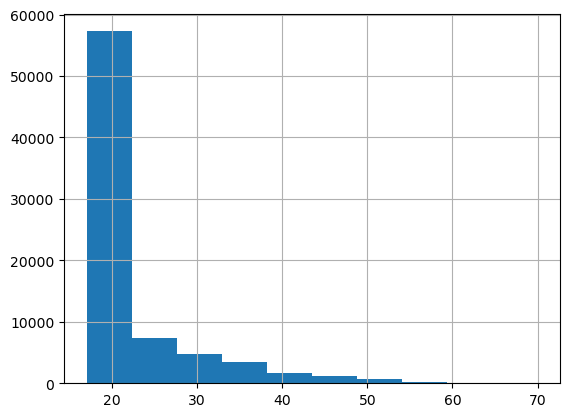

In [14]:
age_col = 'Age at enrollment'
train_df[age_col].hist()
age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((train_df[age_col].values>=val[0]) &
                 (train_df[age_col].values<=val[1]))
    no_col = train_df.shape[1]-1
    train_df.insert(no_col, key, group)

    group = 1*((test_df[age_col].values>=val[0]) &
                 (test_df[age_col].values<=val[1]))
    test_df.insert(no_col, key, group)

In [32]:
x = train_df.iloc[:,:-1].values
y = train_df.iloc[:,-1].values
columns = list(train_df.columns)[:-1]

x_test = test_df.iloc[:,:-1].values

ALL_FEATURES = columns

In [34]:
cols = ALL_FEATURES
interactions = []
for i, c1 in enumerate(cols):
    interactions.append(['*', c1, c1])
    for c2 in cols[i+1:]:
        interactions.append(['*', c1, c2])
        interactions.append(['/', c1, c2])


In [76]:
cols

[['*', 'Scholarship holder', 'Curricular units 1st sem (grade)'],
 ['*', 'Curricular units 2nd sem (grade)', '+65'],
 ['/', 'Marital status', '35-65'],
 ['*', 'Curricular units 2nd sem (without evaluations)', '+65'],
 ['*', 'Curricular units 2nd sem (grade)', '25-35'],
 ['*', 'Application mode', "Mother's occupation"],
 ['/', "Mother's occupation", 'Tuition fees up to date'],
 ['*',
  'Curricular units 2nd sem (evaluations)',
  'Curricular units 2nd sem (without evaluations)'],
 ['*', 'Debtor', 'Curricular units 2nd sem (approved)'],
 ['/',
  'Curricular units 1st sem (evaluations)',
  'Curricular units 2nd sem (grade)'],
 ['/', 'Marital status', 'Course'],
 ['/', "Father's occupation", 'Curricular units 1st sem (approved)'],
 ['*',
  'Curricular units 2nd sem (approved)',
  'Curricular units 2nd sem (approved)'],
 ['*', 'Previous qualification', "Father's occupation"],
 ['/', 'Scholarship holder', '+65'],
 ['/', 'Course', 'Previous qualification (grade)'],
 ['/', 'Gender', '35-65'],
 

In [77]:
sc = MinMaxScaler()
x_scaled = sc.fit_transform(x)
x_test_scaled = sc.transform(x_test)

x_copy = x_scaled.copy()
x_test_copy = x_test_scaled.copy()

feature_copy = ALL_FEATURES.copy()

cols = [
        ['*', 'Course', 'Curricular units 1st sem (evaluations)'],
        ['/', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)'],
        ['*', 'Scholarship holder', 'Curricular units 2nd sem (approved)'],
        ['*', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)'],
        ['*', "Father's occupation", "Mother's occupation"],
        ['/', 'Tuition fees up to date', 'Course'],
        ['/', 'Scholarship holder', '20-25']
]
for s, f1, f2 in cols:
        i = ALL_FEATURES.index(f1)
        j = ALL_FEATURES.index(f2)
        if s=='*':
                a = x_copy[:, i] * x_copy[:, j]
                b = x_test_copy[:, i] * x_test_copy[:, j]
        else:
                a = x_copy[:, i] / (0.0001+x_copy[:, j])
                b = x_test_copy[:, i] / (0.0001+x_test_copy[:, j])

        feature_copy.append("{}{}{}".format(f1, s, f2))
        x_copy = np.column_stack((x_copy, a))
        x_test_copy = np.column_stack((x_test_copy, b))

print(x_copy.shape, x_test_copy.shape)

(76518, 47) (51012, 47)


- Feature Correlations

Top 20 highly correlated features:
                                                     Row  \
934   Curricular units 2nd sem (grade)*Curricular un...   
803       Course*Curricular units 1st sem (evaluations)   
400                 Curricular units 2nd sem (enrolled)   
879   Scholarship holder*Curricular units 2nd sem (a...   
372                 Curricular units 2nd sem (credited)   
459                 Curricular units 2nd sem (approved)   
956             Father's occupation*Mother's occupation   
957             Father's occupation*Mother's occupation   
928   Curricular units 2nd sem (grade)*Curricular un...   
65                                  Father's occupation   
490                    Curricular units 2nd sem (grade)   
933   Curricular units 2nd sem (grade)*Curricular un...   
495                    Curricular units 2nd sem (grade)   
927   Curricular units 2nd sem (grade)*Curricular un...   
324                    Curricular units 1st sem (grade)   
1053                

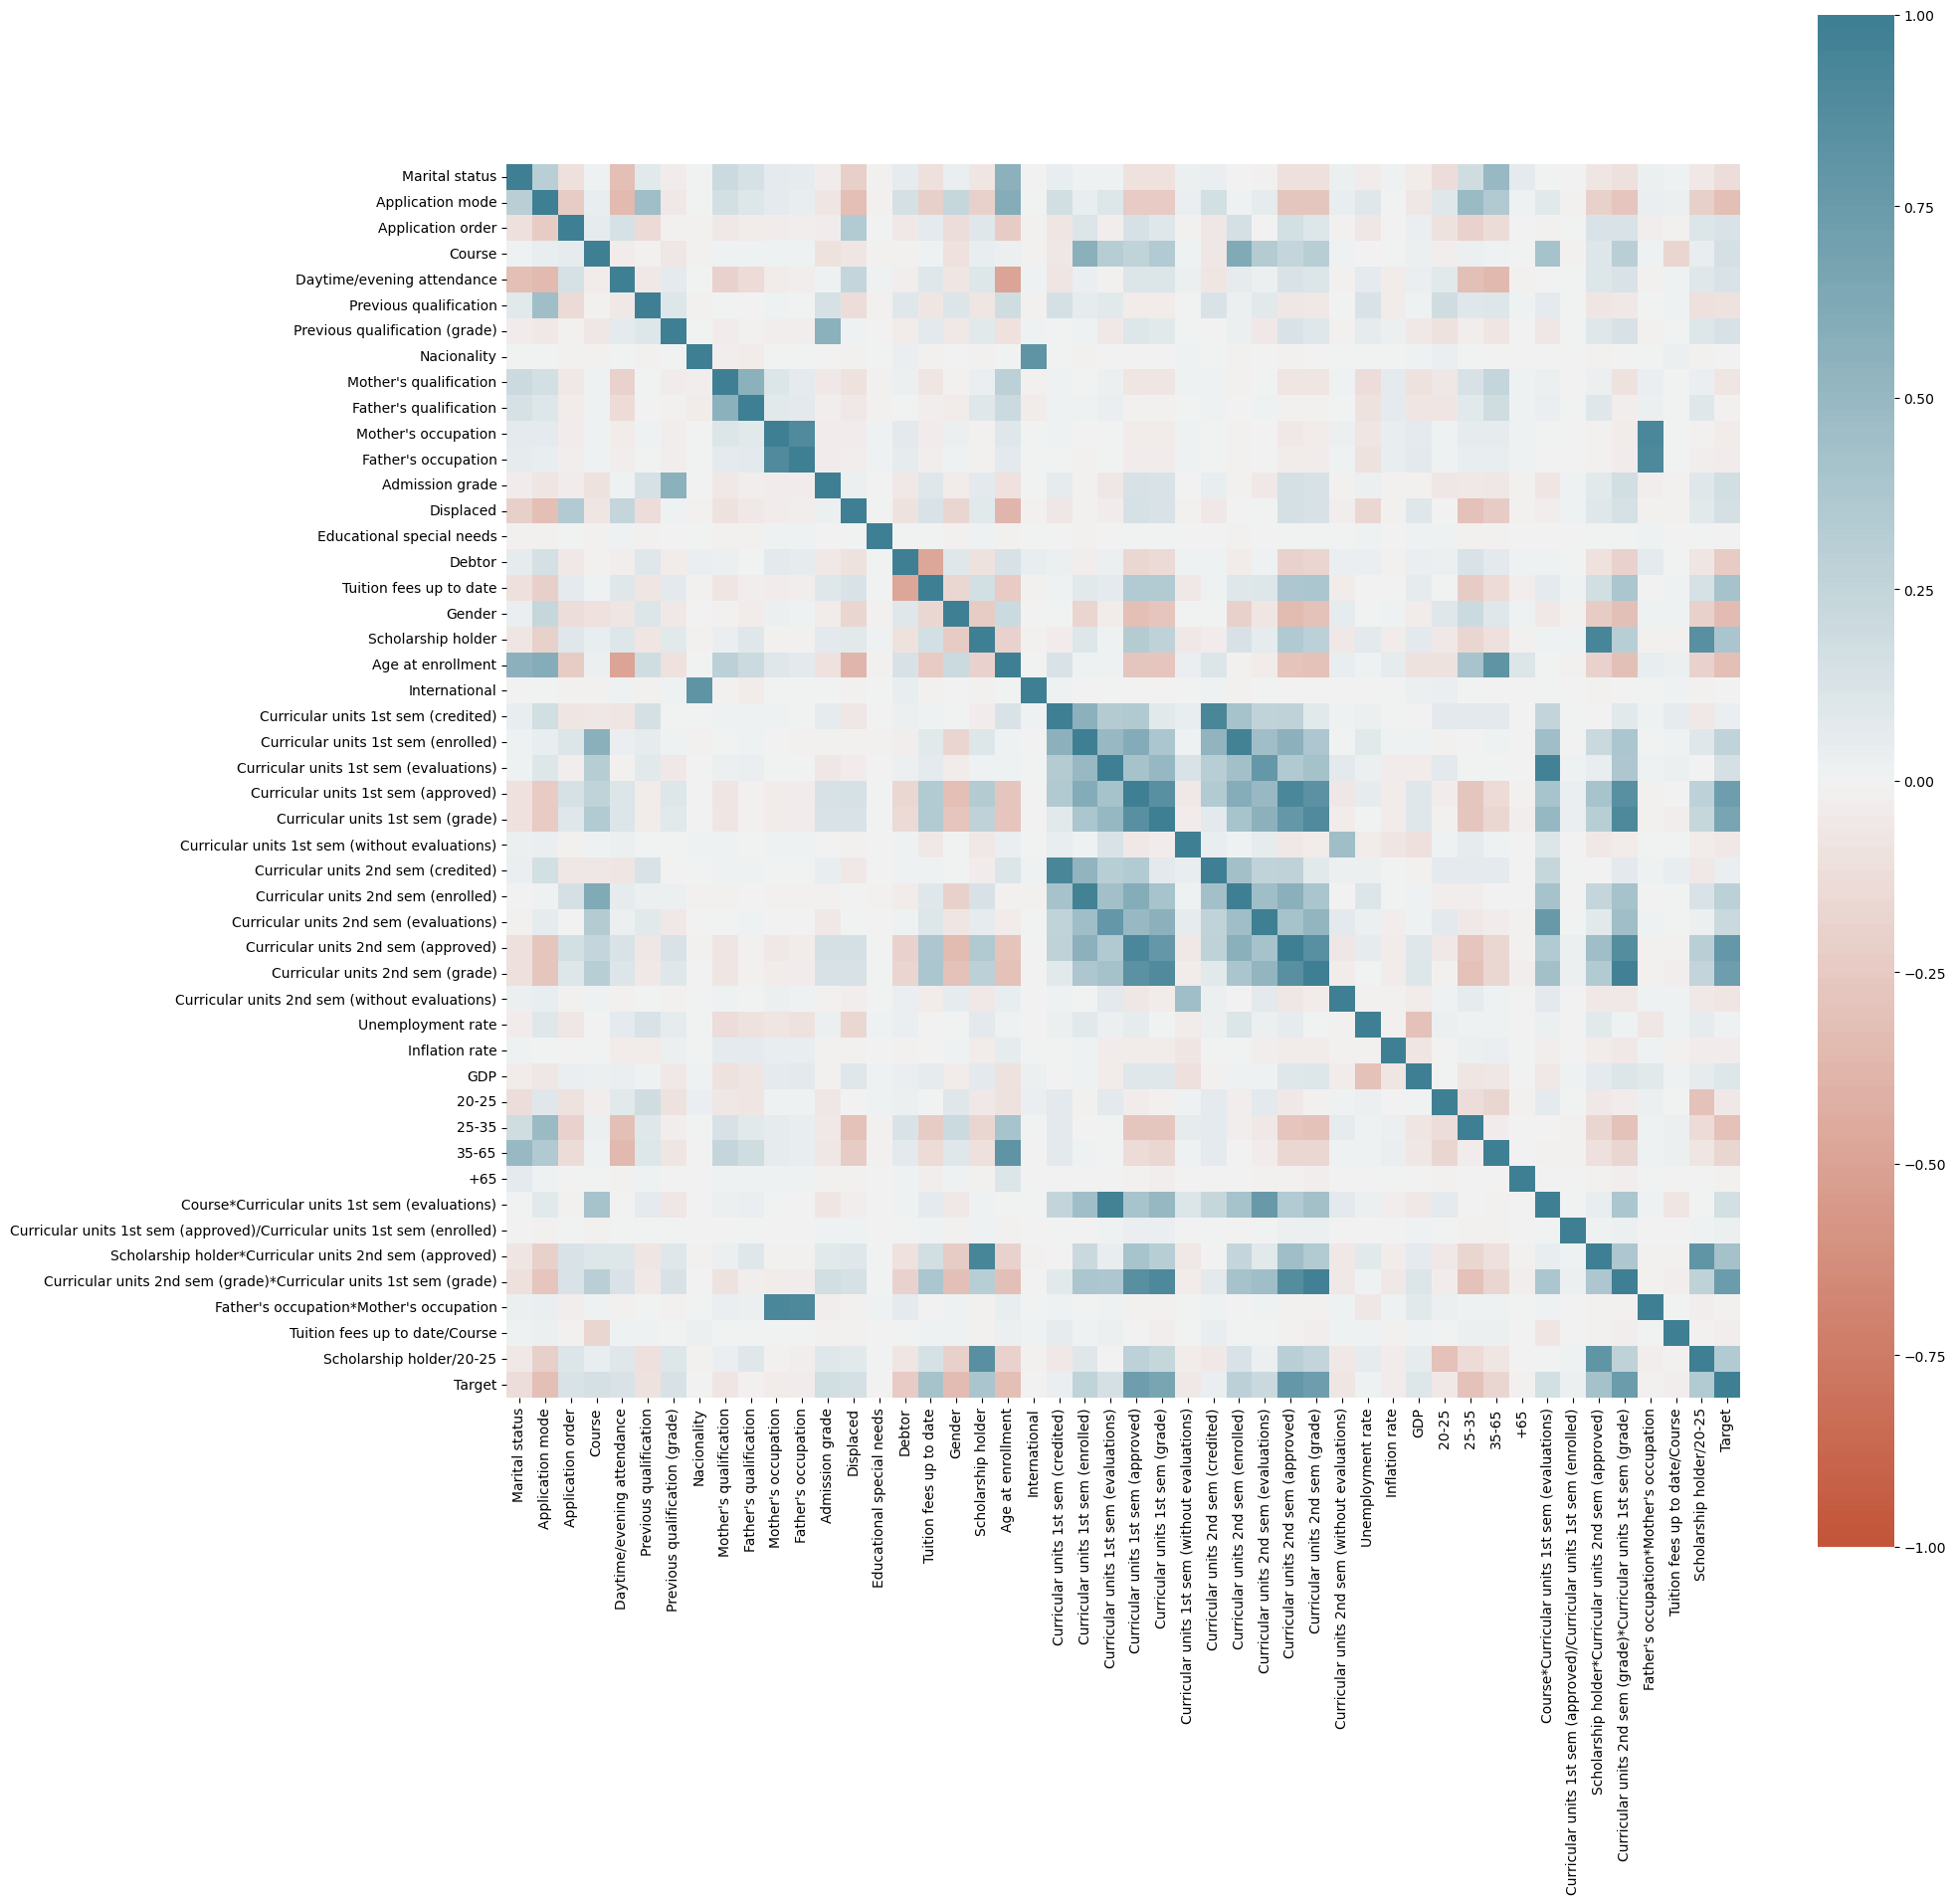

In [78]:
import seaborn as sns

target = 'Target'
copy_df = pd.DataFrame(x_copy.astype('float'),columns=feature_copy)
copy_df[target] = y

corr = copy_df.corr().fillna(0)
fig,ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

is_lower_triangle = 1- np.triu(np.ones(corr.shape)).astype('bool')
df = corr.where(is_lower_triangle==1)
df = df.stack().reset_index()
df.columns = ['Row','Column','value']

df['value'] = np.abs(df['value'].values)
df.sort_values(by='value', ascending=False, inplace=True)

print("Top 20 highly correlated features:\n",
    df.head(20))

print("\nTop 20 features correlated to Y :\n",
    df.query(f'`Row`=="{target}"').head(20))

- Drop Correlated features

In [79]:
y_col = 'Target'
threshold = 0.995

correlated_feautres = set()
seen_features = set()
for i, row in df.iterrows():
    if row['Row']== y_col or row['Column'] == y_col:
        continue

    if row['value']<threshold or \
        row['Row']== row['Column']:
        continue
    if row['Row'] in seen_features or\
        row['Column'] in seen_features:
         continue
    seen_features.add(row['Row'])
    seen_features.add(row['Column'])
    if  row['Row'] not in correlated_feautres:
        correlated_feautres.add(row['Column'])

is_correlated = []

for i,f in enumerate(feature_copy):
    if f not in correlated_feautres:
        is_correlated.append(i)
feature_copy = list(np.array(feature_copy)[is_correlated])
x_copy = x_copy[:,is_correlated]
x_test_copy = x_test_copy[:,is_correlated]
feature_copy

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Previous qualification (grade)',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Admission grade',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rat

- Feature Importance

TOP 30 important features
                                              feature     score
30                Curricular units 2nd sem (approved)  0.473725
16                            Tuition fees up to date  0.106667
18                                 Scholarship holder  0.040262
41  Curricular units 1st sem (approved)/Curricular...  0.036249
28                Curricular units 2nd sem (enrolled)  0.029196
29             Curricular units 2nd sem (evaluations)  0.023350
45                     Tuition fees up to date/Course  0.020022
40      Course*Curricular units 1st sem (evaluations)  0.017527
15                                             Debtor  0.014755
31                   Curricular units 2nd sem (grade)  0.014401
17                                             Gender  0.013165
42  Scholarship holder*Curricular units 2nd sem (a...  0.012807
43  Curricular units 2nd sem (grade)*Curricular un...  0.010317
22                Curricular units 1st sem (enrolled)  0.009041
4             

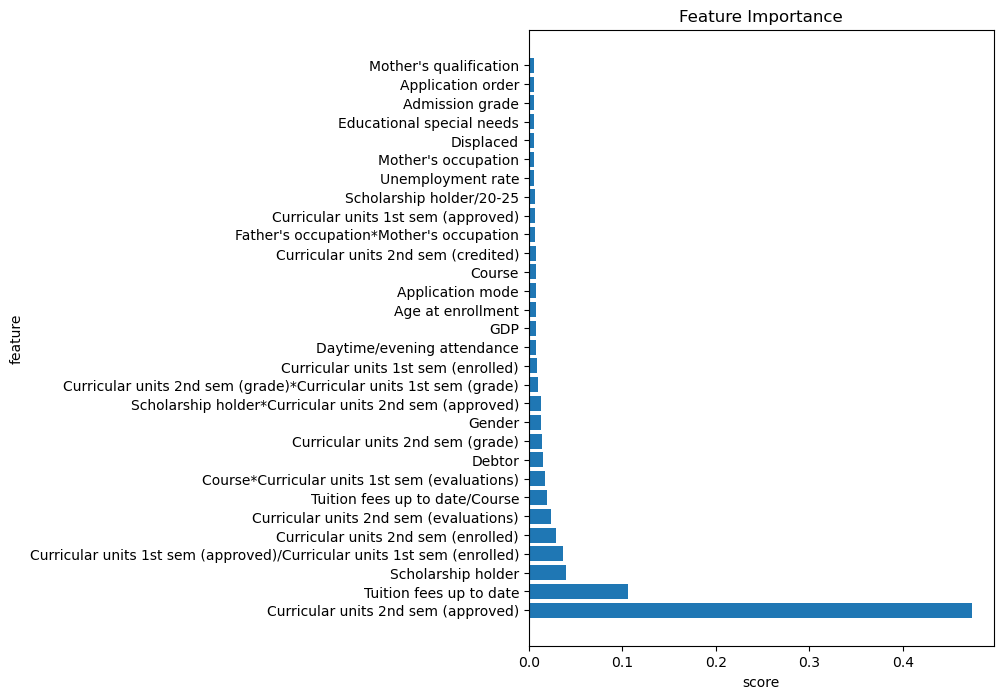

In [80]:
im_df = feature_importance(x_copy, y, feature_copy, is_classifer=True, top_k=30)

- Drop un-important features

In [83]:
unimportant_feautres= im_df.query('score < 0.002')['feature'].values

is_important = []

for i,f in enumerate(feature_copy):
    if f not in unimportant_feautres:
        is_important.append(i)
feature_copy = list(np.array(feature_copy)[is_important])
x_copy = x_copy[:,is_important]
x_test_copy = x_test_copy[:,is_important]

print(x_copy.shape, x_test_copy.shape)

(76518, 46) (51012, 46)


## Model Development

(76518, 46) (76518,)


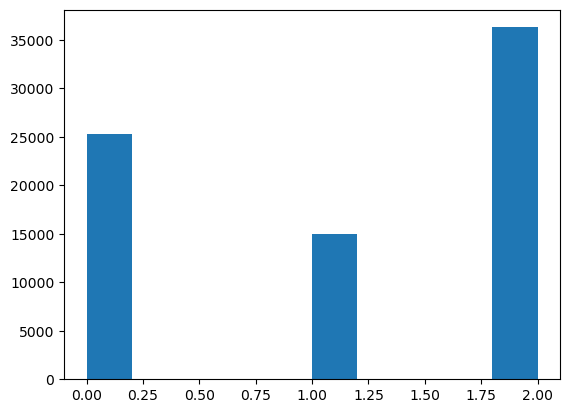

In [84]:
x_train, y_train = x_copy, y
print(x_train.shape, y_train.shape)

plt.hist(y_train)
plt.show()

- Find best model

In [86]:
def cross_validation(model, x, y, n_fold=5):
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=123)

    steps = [("norm", MinMaxScaler()), ("model", model)]
    model = Pipeline(steps=steps)
    res = []
    fold = 1
    for i_in, i_out in kfold.split(x, y):
        print(
            "training a {} (fold {} of {})...".format(key, fold, n_fold),
            end="\r",
        )
        model.fit(x[i_in, :], y[i_in])
        score = accuracy_score(y[i_out], model.predict(x[i_out, :]))
        print(
            "{} (fold {} of {}) Accuracy = {:.3f}".format(key, fold, n_fold, score),
            end="\r",
        )
        res.append(score)
        fold += 1
    print("Avg. Accuracy = {:.3f}".format(np.mean(res)))

In [87]:
models = {
    "lgb": LGBMClassifier(random_state=123, objective= 'multiclass_ova', metric='multi_logloss',verbose=0),
    "xgb": XGBClassifier(random_state=123, objective= 'multi:softmax'),
}
for model in models.values():
    cross_validation(model, x_train, y_train)

c:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\ProgramData\Anaconda3\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\ProgramData\Anaconda3\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\Anaconda3\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Avg. Accuracy = 0.830Accuracy = 0.829
Avg. Accuracy = 0.830Accuracy = 0.829


- Tune a model

In [88]:
from typing import Literal

def tune_a_classifier(
    model: Literal["rf", "xgb", "lgbm"],
    x: np.ndarray,
    y: np.array,
    random_search: bool = True,
    n_iter:int = 50,
    random_state: int = 123,
) -> [object, object]:
    """tune_a_model tunes an random forest or xgboost hyperparameters

    Parameters
    ----------
    model : str
        model type, can be one of ["rf", "xgb", "lgbm"]
    x : np.ndarray
        x data
    y : np.array
        y data
    random_search : bool, optional
        a toggle to switch random or grid search, by default True

    Returns
    -------
    [object, object]
        best_estimator and best_params
    """
    if model == "rf":
        grid = {
            "n_estimators": [20, 50, 100, 200, 300, 400, 600],
            "criterion": ["gini", "entropy"],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "random_state": [random_state],
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False],
            "class_weight": [None, "balanced", "balanced_subsample"],
        }
        estimator = RandomForestClassifier(random_state=random_state)
    elif model == "xgb":
        grid = {
            "learning_rate": [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02],
            "n_estimators": [300, 400, 600, 800, 1000],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_child_weight": [1, 3, 5, 10, 100],
            "gamma": [0, 0.1, 0.2, 0.3],
            "subsample": [0.4,0.5,0.6,0.7,0.8,1.0],
            "colsample_bytree": [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
            'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 
            'reg_lambda': [0.001, 0.01, 0.1, 1, 10],
            "objective": ["multiclass_ova"],
            'random_state': [random_state],
            'tree_method':['hist'],
            }
        estimator = XGBClassifier(random_state=random_state)
    elif model == "lgbm":
        grid = {
        'random_state': [random_state],
        "n_estimators": [2000], 
        'num_classes': [7],
        'objective': ['multi:softmax'], 
        'metric': ['auc'], 
        'learning_rate': [0.006,0.008,0.01,0.014,0.017,0.02],
        'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 
        'reg_lambda': [0.001, 0.01, 0.1, 1, 10],
        'num_leaves' : [3, 15, 31, 63, 127],
        'n_jobs': [-1],
        'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
        'subsample': [0.4,0.5,0.6,0.7,0.8,1.0],
        'max_depth': [1, 10,20,100, -1],
        'min_child_samples': [20, 50, 100],
        "min_split_gain": [0.0,0.1,0.2,0.3],
        "boosting_type": ["gbdt", "dart", "goss"],
        }
        estimator = LGBMClassifier(random_state=random_state)
    else:
        print("Please define the model you want to tune first!")

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring="multi_logloss",
        n_jobs=-1,
        cv=kfold,
        verbose=1,
    )
    if random_search:
        grid_search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=grid,
            n_iter=n_iter,
            cv=kfold,
            verbose=1,
            scoring="f1_macro",
            random_state=random_state,
            n_jobs=-1,
        )
    
    grid_search.fit(x, y)
    print(grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_

In [91]:
#lgbm_model, lgb_param = tune_a_classifier('lgbm',x_train[:2000], y_train[:2000], 
#                                            random_search=True)
lgbm_model = models['lgb']

In [92]:
lgbm_model.fit(x_train, y_train)

im_df = pd.DataFrame(
    {"feature": feature_copy, "score": lgbm_model.feature_importances_}
).sort_values(by="score", ascending=False)

display(im_df.head(20))


,feature,score
12,Admission grade,672
30,Curricular units 2nd sem (approved),555
31,Curricular units 2nd sem (grade),467
42,Curricular units 2nd sem (grade)*Curricular un...,441
6,Previous qualification (grade),425
29,Curricular units 2nd sem (evaluations),419
40,Curricular units 1st sem (approved)/Curricular...,410
25,Curricular units 1st sem (grade),352
3,Course,342
19,Age at enrollment,337


## Model Production

In [94]:
y_pred_test = lgbm_model.predict(x_test_copy)
y_pred_test = label_encoder.inverse_transform(y_pred_test)
df = pd.DataFrame({
    'id': test_id,
    'Target': y_pred_test
})
df.to_csv('submission.csv', index=False)

In [152]:
df2 = pd.read_csv('submission - 0.9.csv')
y_pred_test1 = df2['NObeyesdad'].map(weight_group).values
accuracy_score(y_pred_test, y_pred_test1)

0.983164739884393